In [2]:
import torch
import numpy as np
import mediapy
import pickle
from scipy.io import savemat
import argparse
from tqdm import tqdm
from auxiliar.tracking_viz import generate_frame_image_cv

import matplotlib.pyplot as plt
from src.ortho_factorization import marques_factorization
import rerun as rr
from src.mat_compl import alternating_matrix_completion

%load_ext autoreload
%autoreload 2


In [3]:
import cv2 as cv
from auxiliar.read_video import read_video_or_images
from src.tapnext_infer import init_tapnext

model_video_size = (256, 256)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda:0"

#path = "../mast3r/images_in/casa_bea_4_photos"
path = "../mast3r/images_in/lixo_lab.mp4"
#video_resized, video = read_video_or_images("../mast3r/images_in/bordalo.mp4",model_video_size, device)

video_resized, video = read_video_or_images(path,model_video_size)

torch.cuda.empty_cache()

Reading video: lixo_lab.mp4:   4%|████▏                                                                                          | 5/115 [00:00<00:02, 47.46frame/s]

Reading video: lixo_lab.mp4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 99.30frame/s]


In [40]:
# Design the query points array in the original video size
step = 70
ys, xs = np.meshgrid(np.linspace(8, video[0].shape[0]-step, step), np.linspace(8, video[0].shape[1]-step, step))
query_points_initial = torch.tensor(
    np.stack(
    [np.zeros(len(xs.flatten())), xs.flatten(), ys.flatten()], axis=1
)[None],dtype=torch.float32).to(device)

#resize the querys points to the model size
query_points_initial[0, :, 1:3] /= torch.tensor([video[0].shape[1] / model_video_size[0], video[0].shape[0] / model_video_size[1]]).to(device) # 1, N, 3(frames,x,y)

#creata tensors for the video information
frame_cut = min(20, len(video))
frame_cut = 106
frame_skip = 4
video_tensor_original = torch.cat([(frame).unsqueeze(0) for frame in video]).unsqueeze(0)[:,0:frame_cut:frame_skip,...].to(device) # 1, time, H, W, 3
video_tensor_resized = torch.cat([(frame).unsqueeze(0) for frame in video_resized]).unsqueeze(0)[:,0:frame_cut:frame_skip,...].to(device) # 1, time, H, W, 3
num_frames = video_tensor_resized.shape[1]
print(num_frames)
torch.cuda.empty_cache()

27


In [49]:
from src.tapnext_infer import run_tapnext, init_alltracker
from src.new_queries import add_new_tracks
from auxiliar.read_video import resize_to_max_side
import utils.saveload
import utils.basic
import utils.improc

mode = "alltracker"  # choose: "alltracker", "tapnext", "cotracker"

match mode:
    # ==============================================================
    case "alltracker":

        model = init_alltracker(device)

        rgbs = resize_to_max_side((video_tensor_original.permute(0,1,4,2,3) + 1) / 2 * 255)
        B, T, C, H, W = rgbs.shape
        
        flows_e, visconf_maps_e, _, _ = model.forward_sliding(
            rgbs[:, 0:], iters=4, sw=None, is_training=False
        )

        # grid in pixel coords
        grid_xy = utils.basic.gridcloud2d(1, H, W, norm=False, device="cpu").float()  # [1,H*W,2]
        grid_xy = grid_xy.permute(0, 2, 1).reshape(1, 1, 2, H, W)  # [1,1,2,H,W]

        traj_maps_e = flows_e + grid_xy  # 1, time, 2, H, W
        torch.cuda.empty_cache()
        output_tensor = traj_maps_e.permute(0,1,3,4,2)  # 1, time, H, W, 2

        output_tensor = traj_maps_e.permute(0, 1, 3, 4, 2).reshape(1, T, H * W, 2)  # 1, time, H*W, 2
        H_orig, W_orig = video_tensor_original.shape[1:3]
        scale_factors = torch.tensor(
            [W_orig / W, H_orig / H],
            device=output_tensor.device,
        )  # [sx, sy]
        output_tensor *= scale_factors

    # ==============================================================
    case "tapnext":
        
        tapnext = init_tapnext(device)

        track_histories = run_tapnext(
            video_tensor_resized,  # send the video resized to the model size
            query_points_initial,
            tapnext,
            device=device,
            new_tracks_flag=False,  # or None
        )
        output = {}

        for track_id, trajectory in tqdm(track_histories.items()):  # per feature
            coords = []
            for t in range(num_frames):  # per frame
                step = next((pos for (frame, pos) in trajectory if frame == t), None)
                coords.append(step if step is not None else torch.tensor([float('nan'), float('nan')]))
            output[track_id] = torch.stack(coords)  # shape: [num_frames, 2]

        output_list = [trajectory.unsqueeze(0) for _, trajectory in output.items()]
        output_tensor = torch.cat(output_list, dim=0).unsqueeze(0).permute(0, 2, 1, 3)  # [1, num_frames, num_feats, 2]

        # Flip x/y and scale back to original video size
        output_tensor = output_tensor[:, :, :, [1, 0]]
        output_tensor *= torch.tensor([
            video[0].shape[1] / model_video_size[0],
            video[0].shape[0] / model_video_size[1]
        ])

        torch.cuda.empty_cache()

    # ==============================================================
    case "cotracker":
        cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker3_offline").to(device)

        pred_tracks, pred_visibility = cotracker(
            video_tensor_original.squeeze().permute(0, 3, 1, 2).unsqueeze(0).float().to(device),
            grid_size=step,
            thr=0.9,
        )  # B T N 2,  B T N 1

        pred_tracks = pred_tracks.cpu()
        pred_visibility = pred_visibility.cpu()

        # Ensure shape [1, T, N, 1]
        if pred_visibility.ndim == 3:
            pred_visibility = pred_visibility.unsqueeze(-1)

        # Visibility mask
        visible_mask = pred_visibility.expand_as(pred_tracks)
        pred_tracks_masked = pred_tracks.clone()
        pred_tracks_masked[~visible_mask] = float('nan')

        # Optional flip if you want consistency
        # pred_tracks_masked = pred_tracks_masked[:, :, :, [1, 0]]

        output_tensor = pred_tracks_masked  # [1, num_frames, num_feats, 2]
        torch.cuda.empty_cache()

    # ==============================================================
    case _:
        raise ValueError(f"Unknown tracking mode: {mode}")

# Unified final output: output_tensor → shape [1, num_frames, num_feats, 2]


loaded weights from https://huggingface.co/aharley/alltracker/resolve/main/alltracker.pth


In [50]:

frame_cut_out = output_tensor.shape[1]

# Calculate the number of visible frames for each track
visible_counts = torch.sum(~torch.isnan(output_tensor[0, :frame_cut_out, :, 0]), dim=0) #shape: #feats

# Filter tracks that are visible for at least 20 frames
visible_tracks_mask = visible_counts >= 1
output_tensor_filtered = output_tensor[:, :frame_cut_out, visible_tracks_mask, :]
output_tensor_filtered.shape

video_tensor_original = video_tensor_original.to("cpu")


torch.cuda.empty_cache()

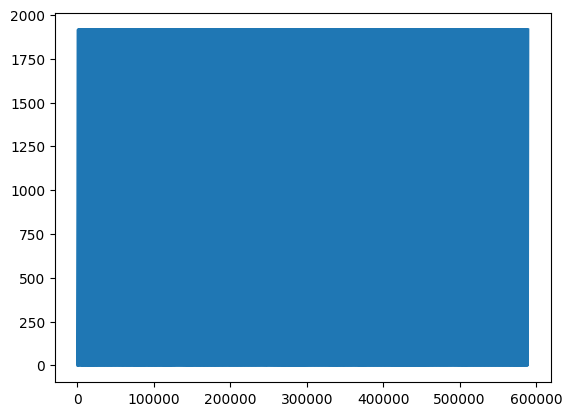

In [79]:
plt.plot(output_tensor[0,0,:,0])

In [ ]:
generate_frame_image_cv(video_tensor_original.cpu(), output_tensor[:,:,::15,:])

Percentage of missing values: 0.00%


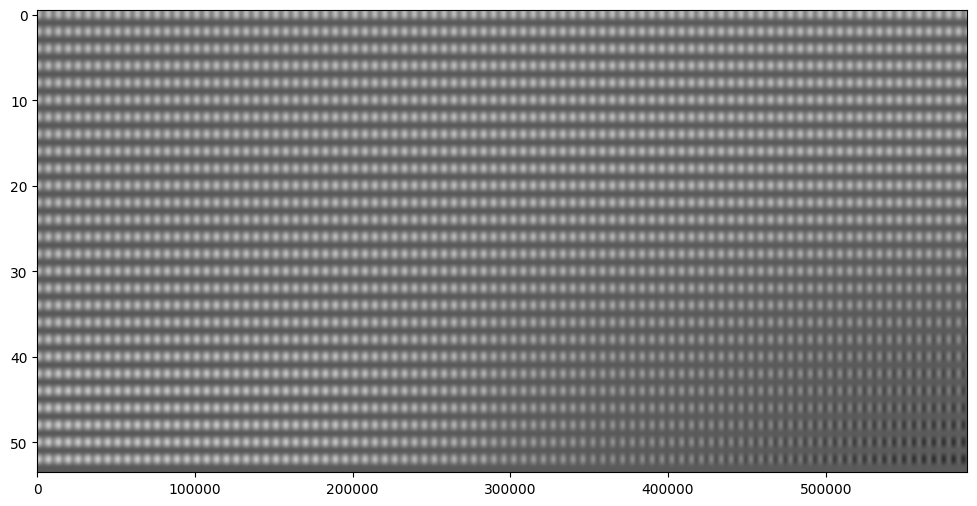

In [53]:
import torch
import matplotlib.pyplot as plt
from src.interpolations import get_rgb_at_coords_torch

# output_tensor_filtered: [1, num_frames, num_feats, 2]
num_frames = output_tensor_filtered.shape[1]
num_feats = output_tensor_filtered.shape[2]

# Build observation matrix: [feats*2, frames]
obs_mat_full = torch.full((num_frames * 2, num_feats), float("nan"), device=output_tensor_filtered.device)

for frame in range(num_frames):  # per frame
    obs_mat_full[frame*2, :] = output_tensor_filtered[0, frame, :, 0]  # x
    obs_mat_full[frame*2+1, :] = output_tensor_filtered[0, frame, :, 1]  # y

# remove columns (features) that have any NaN values
valid_columns_mask_no_nan = ~torch.isnan(obs_mat_full).any(dim=0)
obs_mat = obs_mat_full[:, valid_columns_mask_no_nan]

# remove columns with more than ~50% NaN values
nan_counts = torch.isnan(obs_mat_full).sum(dim=0)
valid_columns_mask_half = nan_counts < (obs_mat_full.shape[0] / 1.3)
obs_mat_half_missed = obs_mat_full[:, valid_columns_mask_half]

# go by feature in obs_mat_half_missed and check first appearance
#for f in range(obs_mat_half_missed.shape[1]):
#    # indices where feature is valid
#    non_nan_idx = torch.where(~torch.isnan(obs_mat_half_missed[:, f]))[0]
#    first_appearance = non_nan_idx // 2  # map back to frame index
#
#    if first_appearance.numel() > 0:
#        fa = first_appearance[0].item()
#        coords = obs_mat_half_missed[fa*2:fa*2+2, f].unsqueeze(0)
#
#        rgb_value = (
#            get_rgb_at_coords_torch(
#                video_tensor_original[0, fa].permute(2, 0, 1),  # CHW
#                coords
#            ) * 255
#        )

# percentage of missing values
missing_percentage = (
    torch.isnan(obs_mat_half_missed).sum().float()
    / (obs_mat_half_missed.numel())
    * 100
).item()

print(f"Percentage of missing values: {missing_percentage:.2f}%")

# plot with torch → numpy just for visualization
plt.figure(figsize=(12, 6))
plt.imshow((obs_mat_half_missed), aspect="auto", cmap="gray" )
plt.show()


Selected features: [3, 9, 1150, 189, 108, 967, 2918, 283, 2501, 2361, 2693, 289, 1910, 732, 2183, 2246, 2537, 1360, 257, 770, 2142, 2225]


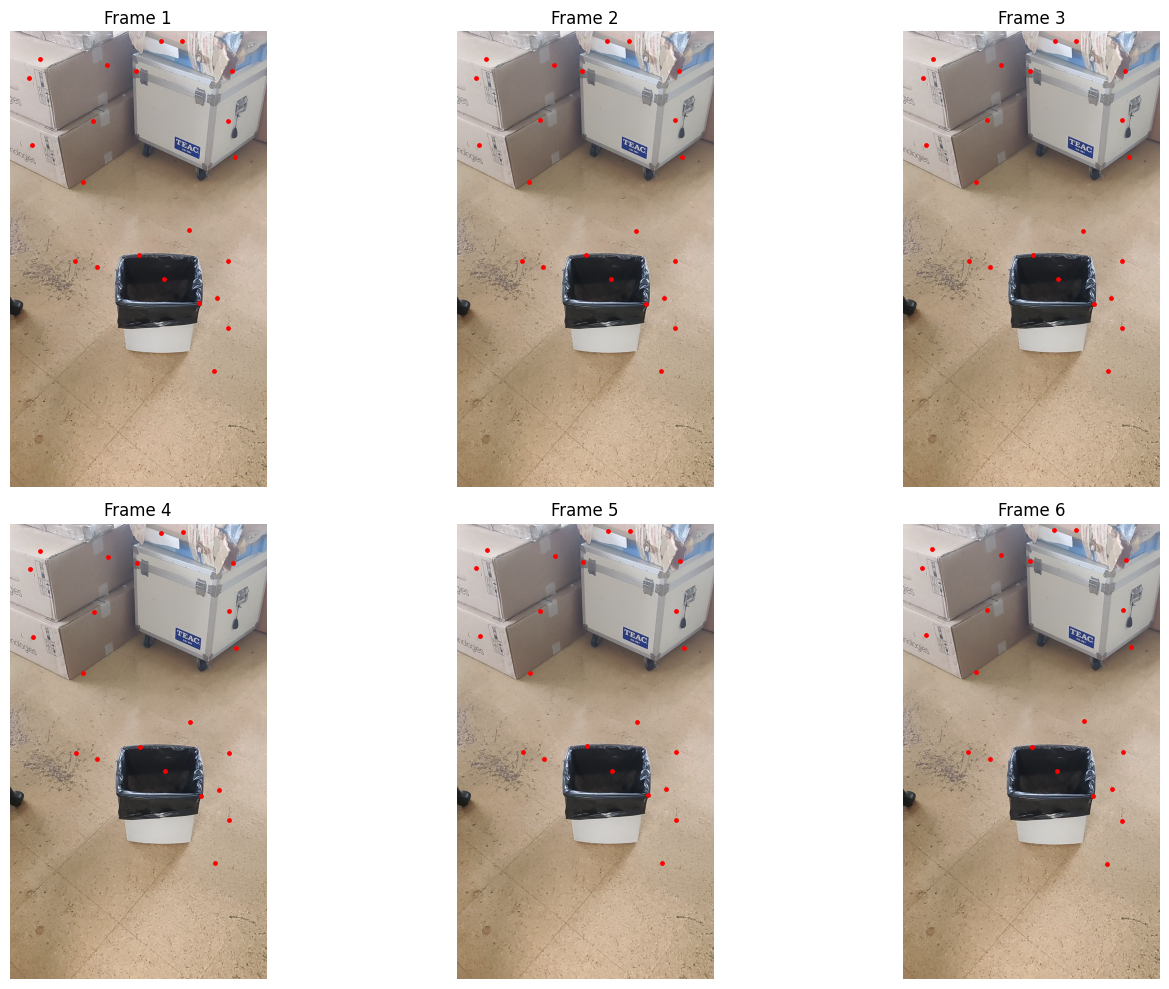

In [42]:
import torch
import matplotlib.pyplot as plt

# obs_mat: [2*frames, feats]
# video: [frames, H, W, C] in [-1, 1] (assumed)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid
axes = axes.flatten()

# Predefined features (convert to torch if you want consistency)
features = torch.tensor([3, 9, 315, 227, 266, 207, 107])
features = torch.tensor([3, 9])
rand_feats = torch.randint(0, obs_mat.shape[1], (20,))

features = torch.cat([features, rand_feats])
print("Selected features:", features.tolist())

# Loop through frames
for i in range(6):
    # Convert frame for plotting
    frame_img = ((video_tensor_original[0,i] + 1) / 2.0)
    axes[i].imshow(frame_img)

    axes[i].scatter(obs_mat[i*2, features], obs_mat[i*2+1, features], s=6, c="red")
    axes[i].set_title(f"Frame {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


Outer Iterations: 100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 107.70it/s]


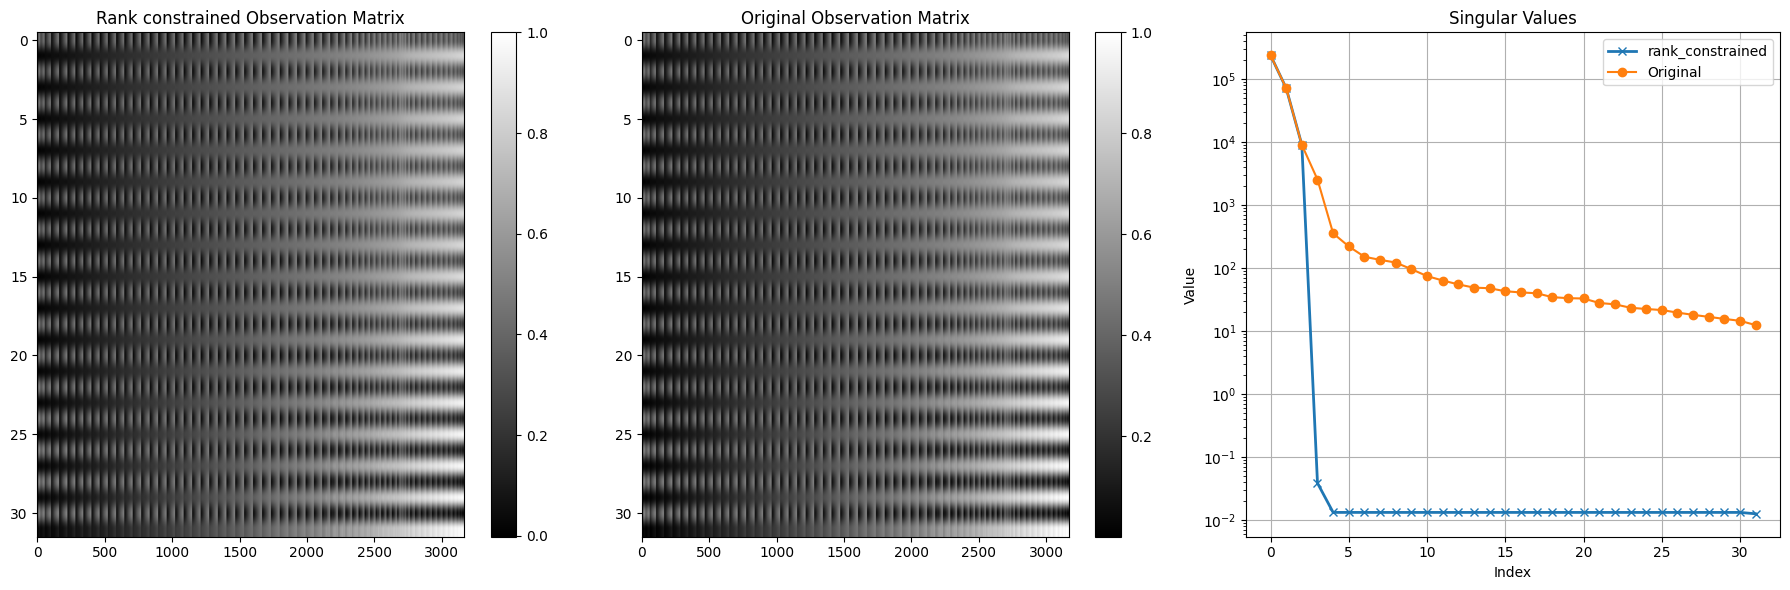

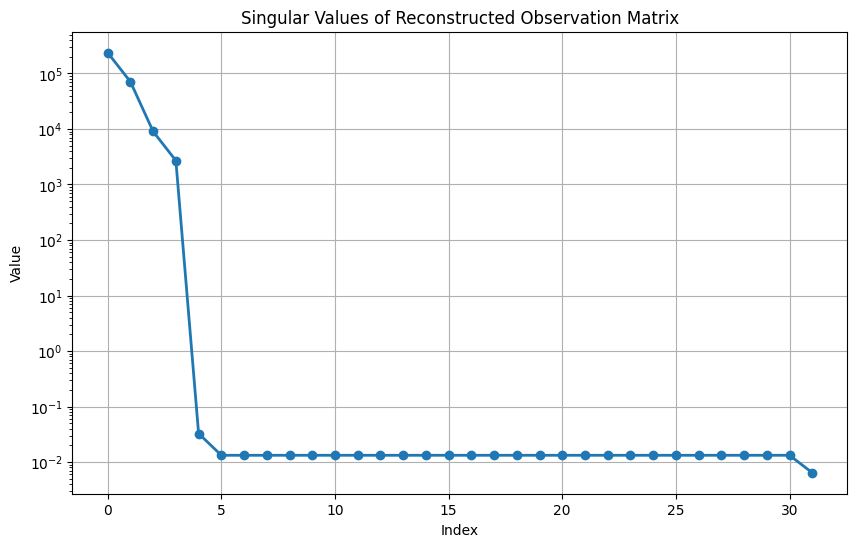

In [43]:
from src.ortho_factorization import costeira_marques
import torch.nn.functional as F


obs_completed, _ = alternating_matrix_completion(obs_mat, mode=0, max_iters=200, rank=3)
# completion + factorization
motion, shape, t = costeira_marques(obs_mat) # rank 3
reconstructed_obs = motion @ shape + t.repeat(1, shape.shape[1])

plt.figure(figsize=(18, 6))

# Plot the completed observation matrix
plt.subplot(1, 3, 1)
plt.imshow(obs_completed / np.nanmax(obs_completed), aspect='auto', cmap='gray')
plt.title("Rank constrained Observation Matrix")
plt.colorbar()

# Plot the original observation matrix
plt.subplot(1, 3, 2)
plt.imshow(obs_mat / np.nanmax(obs_mat), aspect='auto', cmap='gray')
plt.title("Original Observation Matrix")
plt.colorbar()

# Plot the singular values
plt.subplot(1, 3, 3)
singular_values_rank = torch.linalg.svd(obs_completed, full_matrices=False).S
plt.plot(singular_values_rank.cpu().numpy(), "-x", linewidth=2)

singular_values_original = torch.linalg.svd(obs_mat, full_matrices=False).S
plt.plot(singular_values_original.cpu().numpy(), "-o")
plt.legend(["rank_constrained", "Original"])
plt.title("Singular Values")
plt.yscale("log")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()


#plot the singular values of the reconstructed
plt.figure(figsize=(10, 6))
singular_values_reconstructed = torch.linalg.svd(reconstructed_obs, full_matrices=False).S
plt.plot(singular_values_reconstructed.cpu().numpy(), "-o", linewidth=2)
plt.yscale("log")
plt.title("Singular Values of Reconstructed Observation Matrix")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()


In [45]:
# testing costeira marques
rr.init("3d_vggt")
rr.notebook_show(width=int(1920*0.75), height=int(1080*0.75))
rr.log("/costeira_marques", rr.Points3D(shape.numpy().T))


# just do the svd and extract the 3d points
#U, S, Vh = torch.linalg.svd(obs_completed, full_matrices=False) 
#S3 = torch.diag(S[:3])
#shape_svd = torch.sqrt(S3) @ Vh[:3, :]
#rr.log("/rank_enforced_w", rr.Points3D(shape_svd.numpy().T))

Viewer()

In [46]:
import grpc
import os
import sys
import json

sys.path.append('../boxes/vggt/protos')
import pipeline_pb2 as vggt_pb2
import pipeline_pb2_grpc as vggt_pb2_grpc
from aux import wrap_value, unwrap_value
from PIL import Image
import io

image_byte_list = []
# List all files in the directory
if 0:
    files = [os.path.join(path, file) for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))]

    for file in sorted(files):
        # Open the file in binary read mode ('rb') and read its entire content
        with open(file, 'rb') as f:
            image_bytes = f.read()
            image_byte_list.append(image_bytes)
            print(f"Read {file}: {len(image_bytes) / (1024 * 1024):.2f} MB")

else:

    # Convert video frames (tensor) to a list of byte arrays
    for frame in video_tensor_original[0]:  # Assuming video_tensor_original is [1, time, H, W, C]
        # Convert tensor to numpy array and scale to [0, 255]
        frame_np = (frame.numpy() * 255).astype('uint8')
        # Create an Image object
        img = Image.fromarray(frame_np)
        # Save the image to a bytes buffer
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG")
        # Append the bytes to the list
        image_byte_list.append(buffer.getvalue())

config_json = {
        "command": "3d_infer",
        "parameters": {
            "device": "cuda:1", # TODO: implement this
            "conf_vis": 50.0
        }
}

request = vggt_pb2.Envelope(data={"images":wrap_value(image_byte_list)},
                            config_json = json.dumps(config_json))
channel_opt = [('grpc.max_send_message_length', -1), ('grpc.max_receive_message_length', -1)]
channel=grpc.insecure_channel("localhost:8061",options=channel_opt)
estimator_stub = vggt_pb2_grpc.PipelineServiceStub(channel)
response = estimator_stub.Process(request)
channel.close()

#write the glb as a file
glb_file = unwrap_value(response.data["glb_file"])
with open("output.glb", "wb") as f:
    f.write(glb_file)
    

In [47]:
from auxiliar.depth_tensor_viz import k3d_3d_plot, plot_depth_tensor_grid
wrld_pts = np.load(io.BytesIO(unwrap_value(response.data["world_points"]))).squeeze().reshape(-1,3)
wrld_conf = np.load(io.BytesIO(unwrap_value(response.data["world_points_conf"]))).squeeze().reshape(-1,1)
                    
k3d_3d_plot(wrld_pts[wrld_conf.flatten() > 1, :][::50].T)

Output()

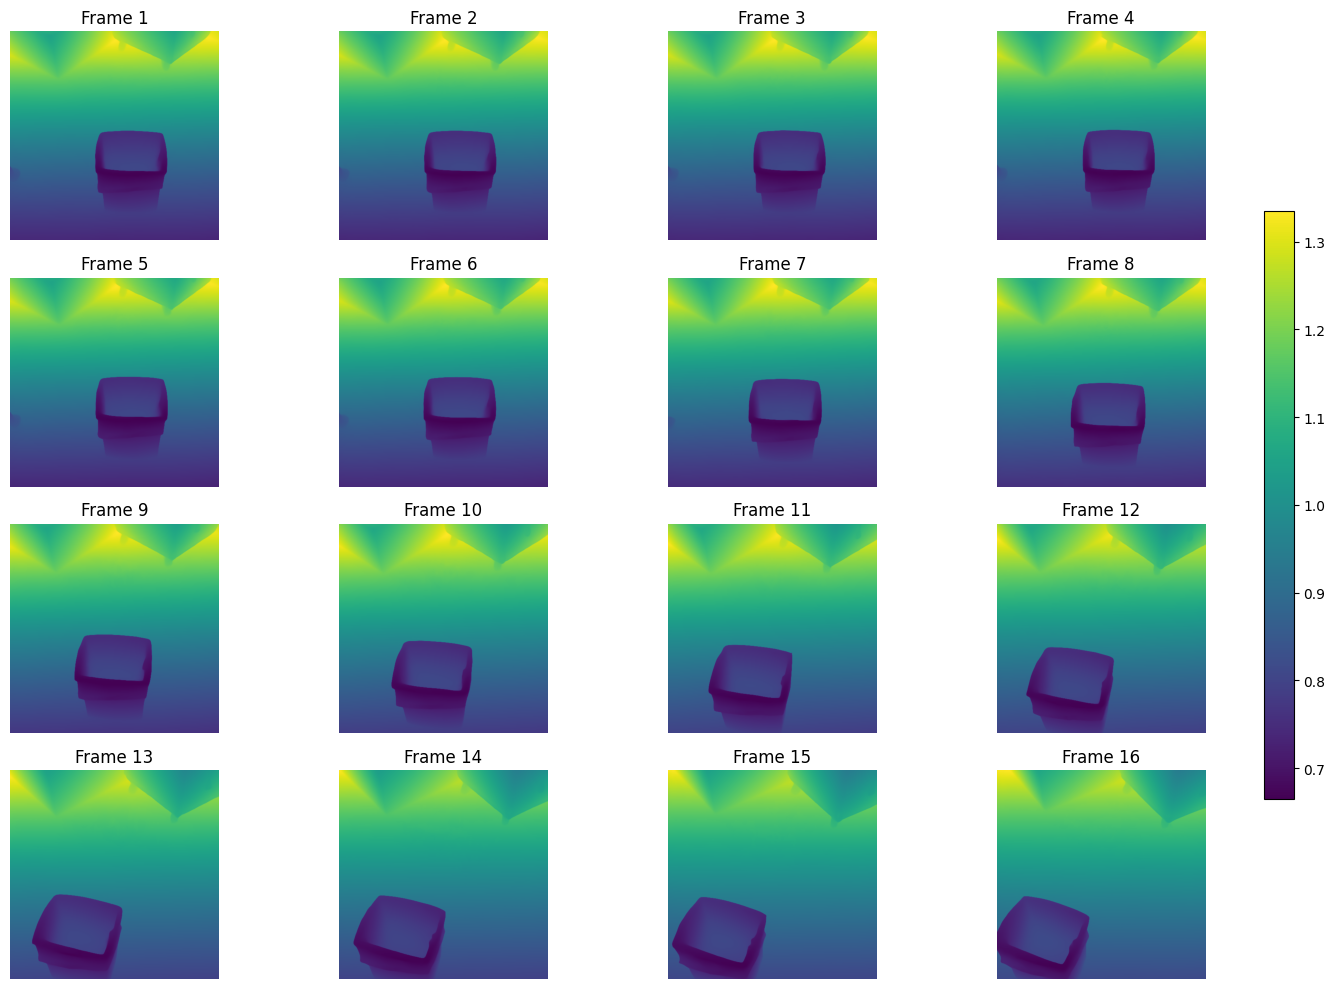

(<Figure size 1500x1000 with 17 Axes>,
 array([<Axes: title={'center': 'Frame 1'}>,
        <Axes: title={'center': 'Frame 2'}>,
        <Axes: title={'center': 'Frame 3'}>,
        <Axes: title={'center': 'Frame 4'}>,
        <Axes: title={'center': 'Frame 5'}>,
        <Axes: title={'center': 'Frame 6'}>,
        <Axes: title={'center': 'Frame 7'}>,
        <Axes: title={'center': 'Frame 8'}>,
        <Axes: title={'center': 'Frame 9'}>,
        <Axes: title={'center': 'Frame 10'}>,
        <Axes: title={'center': 'Frame 11'}>,
        <Axes: title={'center': 'Frame 12'}>,
        <Axes: title={'center': 'Frame 13'}>,
        <Axes: title={'center': 'Frame 14'}>,
        <Axes: title={'center': 'Frame 15'}>,
        <Axes: title={'center': 'Frame 16'}>], dtype=object))

In [48]:
plot_depth_tensor_grid(torch.tensor(np.load(io.BytesIO(unwrap_value(response.data["depth"])))))

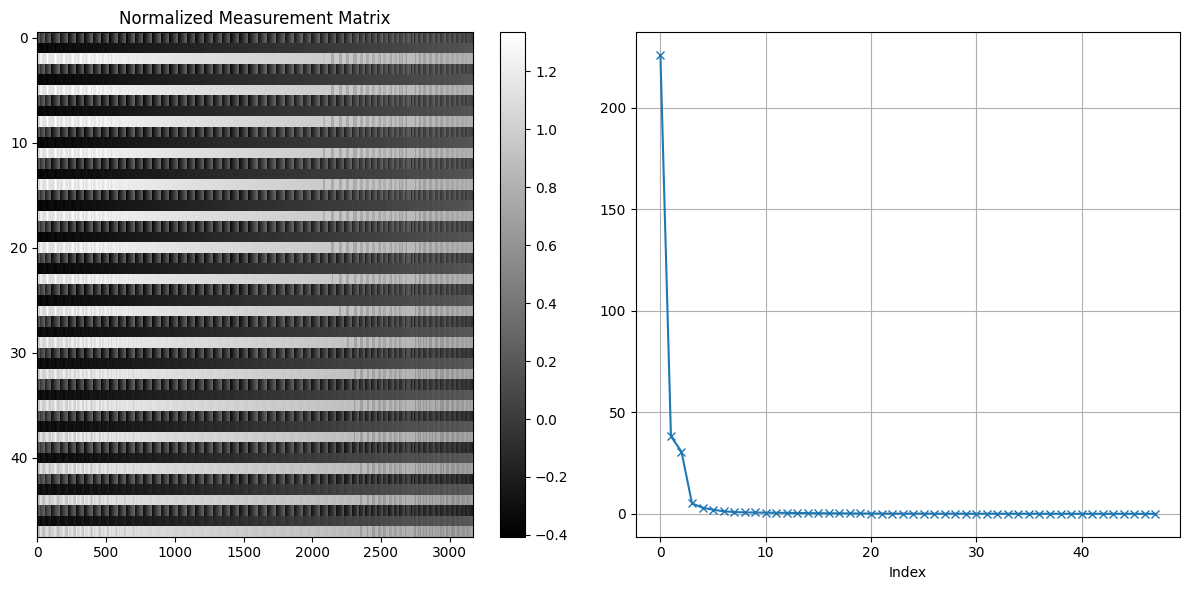

In [49]:
import io
from src.projective_factorization import build_depth_weighted_matrix, normalize_measurement_matrix

vggt_depth_tensor = torch.tensor(np.load(io.BytesIO(unwrap_value(response.data["depth"]))))  # 1, time, H, W, 1
vggt_conf_tensor = torch.tensor(np.load(io.BytesIO(unwrap_value(response.data["depth_conf"]))))  # 1, time, H, W, 1
instrisics = torch.tensor(np.load(io.BytesIO(unwrap_value(response.data["intrinsic"]))))
extrinsics = torch.tensor(np.load(io.BytesIO(unwrap_value(response.data["extrinsic"]))))
wrld_pts = torch.tensor(np.load(io.BytesIO(unwrap_value(response.data["world_points"])))) # 1, #frame, H, W, 3

# need to resize the observation matrix to the size of the depth tensor
W_vggt = obs_mat.clone()
W_vggt[0::2,:] = W_vggt[0::2] * (vggt_depth_tensor.shape[3] / video.shape[2])
W_vggt[1::2,:] = W_vggt[1::2] * (vggt_depth_tensor.shape[2] / video.shape[1])

# average all intrinsic matrices
K_vggt = torch.mean(instrisics, dim=0) # TODO: this needs to be resized due to the tracks
#K = torch.eye(3)

frames_to_use = vggt_depth_tensor.shape[1]
W_depth_vggt, tracks_lambda_vggt = build_depth_weighted_matrix(W_vggt[0:frames_to_use*2,:], vggt_depth_tensor.squeeze()[0:frames_to_use,:],
                                            fx=K_vggt[0,0], fy=K_vggt[1,1], cx=K_vggt[0,2], cy=K_vggt[1,2])

pattern = torch.tensor([1, 1, 0], dtype=torch.bool)
mask = pattern.repeat((W_depth_vggt.shape[0] + len(pattern) - 1) // len(pattern))[:W_depth_vggt.shape[0]]
W_vggt_nohomg = W_depth_vggt[mask, ...]

# Normalize the measurement matrix with isotropic scaling sqrt(3)
Wn, T_list = normalize_measurement_matrix(W_depth_vggt)                     # Wn: [3F, P]

U, S, Vh = torch.linalg.svd(W_depth_vggt, full_matrices=False)
r = 4
Ur = U[:, :r]
Sr = torch.diag(S[:r])
Vr = Vh[:r, :]

Ssqrt = torch.linalg.cholesky(Sr)  
Motion = Ur @ Ssqrt                     
Sshape = Ssqrt @ Vr                # (4,  P) 
W_hat = Motion @ Sshape

#X3d = Sshape[:3, :] / Sshape[3:4, :]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the normalized measurement matrix
im1 = axes[0].imshow(W_depth_vggt, aspect='auto', cmap='gray', interpolation='none')
axes[0].set_title("Normalized Measurement Matrix")
fig.colorbar(im1, ax=axes[0])

# Plot the singular values in log scale
axes[1].plot(torch.linalg.svd(W_depth_vggt)[1], "-x")
axes[1].set_xlabel("Index")
#axes[1].set_title("Log10 Singular Values")
#axes[1].set_yscale('log')
axes[1].grid(True)

plt.tight_layout()
plt.show(fig)


# Factorization of the W_hat with the no homogenous coordinates and the lambda

In [58]:
motion, shape, t = costeira_marques(W_vggt, iterMax1=100)

rr.init("marques_factorization")
rr.notebook_show(width=int(1920*0.75), height=int(1080*0.75))
rr.log("marques_factorization/3d_completed", rr.Points3D(shape.numpy().T))


Outer Iterations: 100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 113.96it/s]


Viewer()

# Another depth estimator model

In [142]:
import sys 
sys.path.append("/home/manuelf/UniDepth/")
from unidepth.models import UniDepthV2

device = "cuda:1"
model = UniDepthV2.from_pretrained("lpiccinelli/unidepth-v2-vitl14").to(device) # or "lpiccinelli/unidepth-v1-cnvnxtl" for the ConvNext backbone


Not loading pretrained weights for backbone
EdgeGuidedLocalSSI reverts to a non cuda-optimized operation, you will experince large slowdown, please install it:  `cd ./unidepth/ops/extract_patches && bash compile.sh`


In [172]:
depths = []
uni_conf = []
uni_focal = []

for frame in range(video_tensor_resized.shape[1]):
    pred = model.infer(video_tensor_resized[0,frame].permute(2,0,1).to(device))
    #rnd = torch.rand(1).to(device) * 100
    rnd = 1
    print(rnd)
    depths.append(pred["depth"] * rnd)
    uni_conf.append(1 / pred["confidence"])
    uni_focal.append(pred["intrinsics"])

uni_depth_tensor = torch.stack(depths).unsqueeze(-1).cpu().squeeze()  # (num_frames, H, W, 1)
uni_conf_tensor = torch.stack(uni_conf).unsqueeze(-1).cpu().squeeze()  # (num_frames, H, W, 1)
uni_focal_tensor = torch.stack(uni_focal).cpu().squeeze()  # (num_frames, 3, 3)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


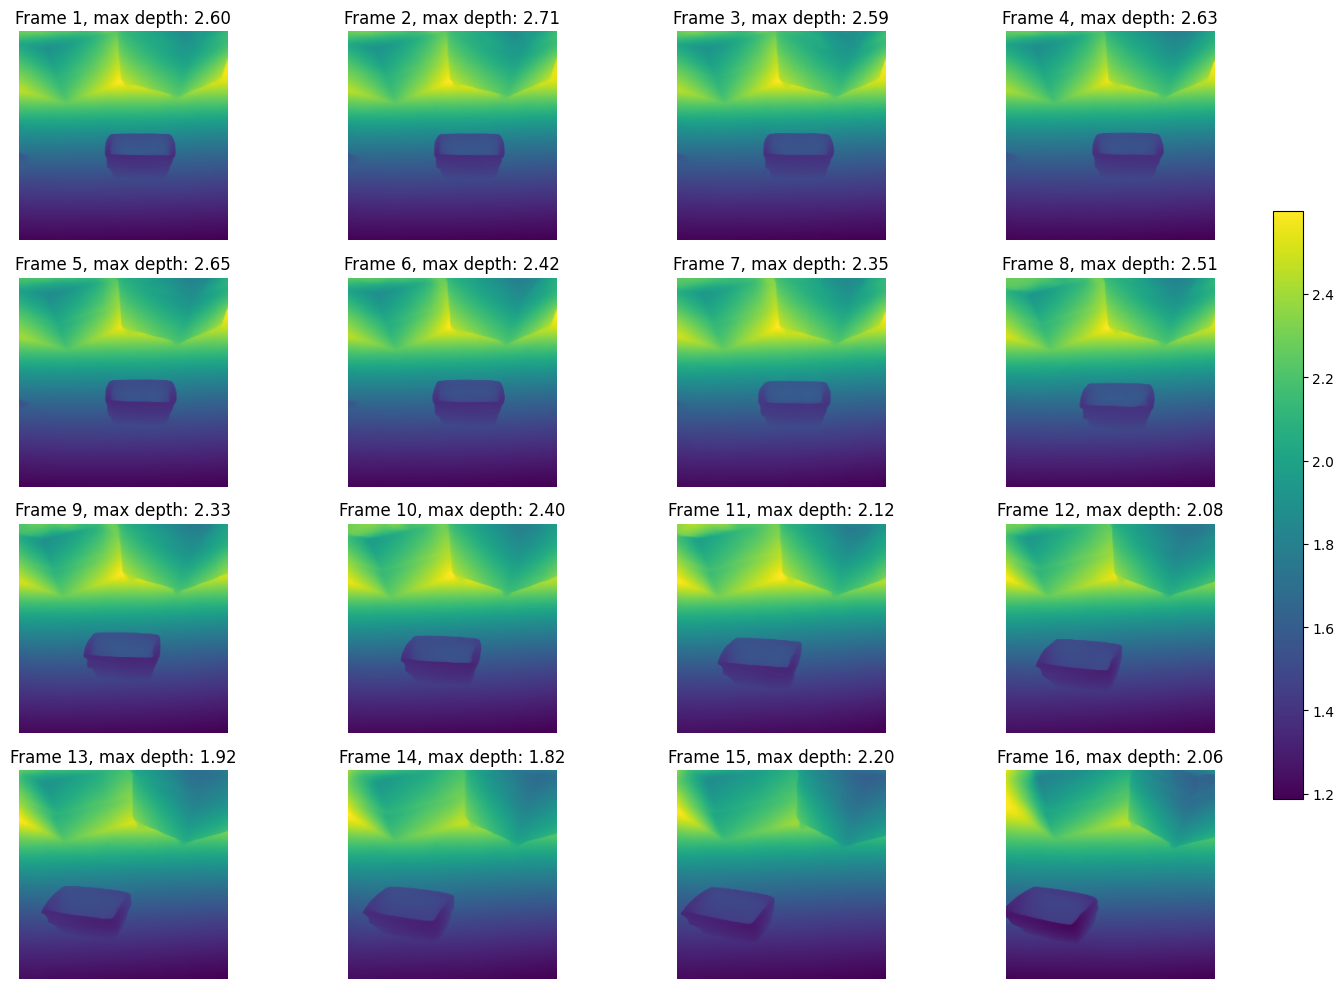

(<Figure size 1500x1000 with 17 Axes>,
 array([<Axes: title={'center': 'Frame 1, max depth: 2.60'}>,
        <Axes: title={'center': 'Frame 2, max depth: 2.71'}>,
        <Axes: title={'center': 'Frame 3, max depth: 2.59'}>,
        <Axes: title={'center': 'Frame 4, max depth: 2.63'}>,
        <Axes: title={'center': 'Frame 5, max depth: 2.65'}>,
        <Axes: title={'center': 'Frame 6, max depth: 2.42'}>,
        <Axes: title={'center': 'Frame 7, max depth: 2.35'}>,
        <Axes: title={'center': 'Frame 8, max depth: 2.51'}>,
        <Axes: title={'center': 'Frame 9, max depth: 2.33'}>,
        <Axes: title={'center': 'Frame 10, max depth: 2.40'}>,
        <Axes: title={'center': 'Frame 11, max depth: 2.12'}>,
        <Axes: title={'center': 'Frame 12, max depth: 2.08'}>,
        <Axes: title={'center': 'Frame 13, max depth: 1.92'}>,
        <Axes: title={'center': 'Frame 14, max depth: 1.82'}>,
        <Axes: title={'center': 'Frame 15, max depth: 2.20'}>,
        <Axes: title={'ce

In [173]:
from auxiliar.depth_tensor_viz import plot_depth_tensor_grid
plot_depth_tensor_grid(uni_depth_tensor)

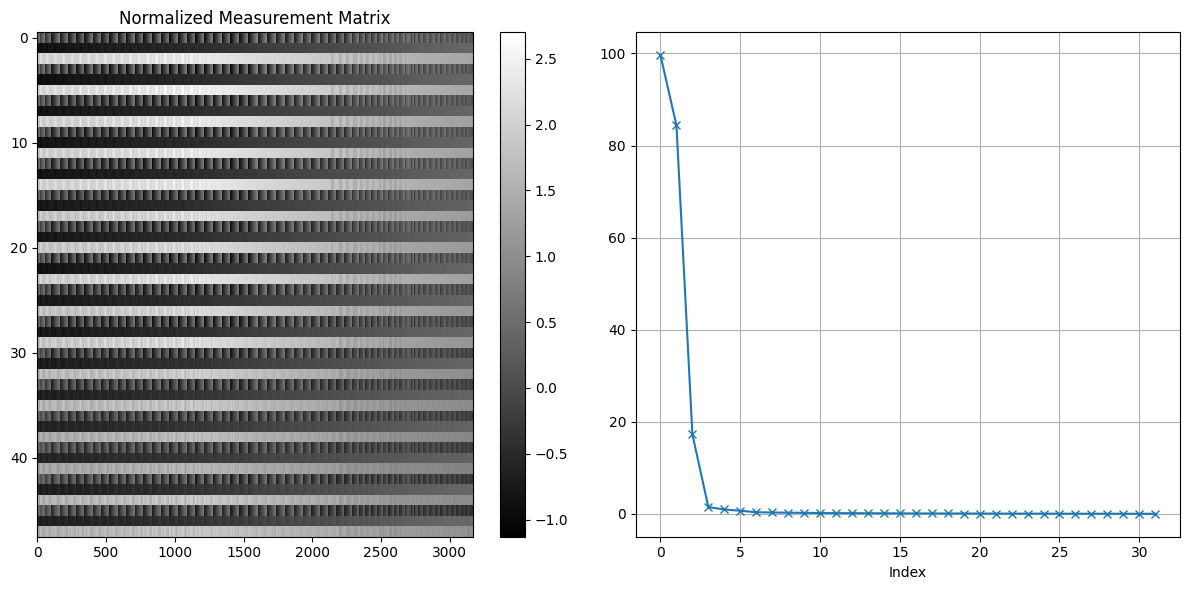

In [174]:
from src.projective_factorization import build_depth_weighted_matrix, normalize_measurement_matrix

# make the tracks fit into the new depth size
W_uni = obs_mat.clone()
W_uni[0::2,:] = W_uni[0::2] * (uni_depth_tensor.shape[1] / video.shape[2])
W_uni[1::2,:] = W_uni[1::2] * (uni_depth_tensor.shape[2] / video.shape[1])

K_uni_mean = torch.mean(uni_focal_tensor, dim=0)
#K = torch.eye(3)

frames_to_use = uni_depth_tensor.shape[0]
W_depth_uni, tracks_lambda_unidepth = build_depth_weighted_matrix(W_uni[0:frames_to_use*2,:], uni_depth_tensor[0:frames_to_use,:],
                                            fx=K_uni_mean[0,0], fy=K_uni_mean[1,1], cx=K_uni_mean[0,2], cy=K_uni_mean[1,2])

pattern = torch.tensor([1, 1, 0], dtype=torch.bool)
mask = pattern.repeat((W_depth_uni.shape[0] + len(pattern) - 1) // len(pattern))[:W_depth_uni.shape[0]]
W_uni_nohomg = W_depth_uni[mask, ...]

Wn, T_list = normalize_measurement_matrix(W_depth_uni)                     # Wn: [3F, P]

U, S, Vh = torch.linalg.svd(Wn, full_matrices=False)
r = 4
Ur = U[:, :r]
Sr = torch.diag(S[:r])
Vr = Vh[:r, :]

Ssqrt = torch.linalg.cholesky(Sr)  
Motion = Ur @ Ssqrt                     
Sshape = Ssqrt @ Vr                # (4,  P) 
W_hat = Motion @ Sshape

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the normalized measurement matrix
im1 = axes[0].imshow(W_depth_uni, aspect='auto', cmap='gray', interpolation='none')
axes[0].set_title("Normalized Measurement Matrix")
fig.colorbar(im1, ax=axes[0])

# Plot the singular values in log scale
axes[1].plot(torch.linalg.svd(W_uni_nohomg)[1], "-x")
axes[1].set_xlabel("Index")
#axes[1].set_title("Log10 Singular Values")
#axes[1].set_yscale('log')
axes[1].grid(True)

plt.tight_layout()
plt.show(fig)


Outer Iterations: 100%|████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 265.35it/s]


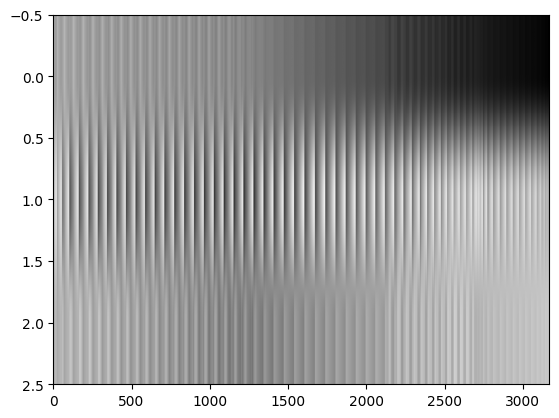

In [175]:
from auxiliar.depth_tensor_viz import k3d_3d_plot
#k3d_3d_plot(costeira_marques(W_depth_uni)[1]) # tomasi
plt.imshow(costeira_marques(W_depth_uni)[1], aspect='auto', cmap='gray')


In [ ]:
import torch

def _norm_uv_per_frame(tracks, K):
    """
    Normalize pixel coordinates per frame using either a single K or per-frame Ks.

    Args:
        tracks : [2F, P]
        K      : [3,3] or [F,3,3]

    Returns:
        x, y : [F, P] normalized coordinates
    """
    F = tracks.shape[0] // 2
    u = tracks[0::2, :]  # [F, P]
    v = tracks[1::2, :]  # [F, P]

    if K.ndim == 2:  # same intrinsics for all frames
        fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]
        x = (u - cx) / fx
        y = (v - cy) / fy
    else:
        # per-frame Ks
        fx = K[:, 0, 0].unsqueeze(1)  # [F,1]
        fy = K[:, 1, 1].unsqueeze(1)
        cx = K[:, 0, 2].unsqueeze(1)
        cy = K[:, 1, 2].unsqueeze(1)
        x = (u - cx) / fx
        y = (v - cy) / fy

    return x, y

def _build_W_ortho(x, y, lam, d, s):
    """ Build the orthographic measurement matrix W given the parameters.
    Args:
        x: normalized x coordinates [F,P]
        y: normalized y coordinates [F,P]
        lam: depth scaling factors [F,P]
        d: scale per frame [F]
        s: translation per frame [F]
    Returns:
        W: measurement matrix [2F,P]
        z: depth adjusted scaling factors [F,P]
    """
    z = d[:,None]*lam + s[:,None]
    W = torch.empty((2*lam.shape[0], lam.shape[1]), device=lam.device, dtype=lam.dtype)
    W[0::2] = x * z
    W[1::2] = y * z
    return W, z

@torch.no_grad()
def _update_affine_ortho(x, y, lam, M, eps=1e-6, clamp_pos=True):
    F, P = lam.shape
    Mx, My = M[0::2], M[1::2]

    X2Y2 = x**2 + y**2              # [F,P]
    L = lam

    a11 = (L*L * X2Y2).sum(1) + eps
    a22 = (X2Y2).sum(1) + eps
    a12 = (L * X2Y2).sum(1)

    b1 = ((L*x)*Mx + (L*y)*My).sum(1)
    b2 = (x*Mx + y*My).sum(1)

    det = a11*a22 - a12*a12 + eps
    d = (a22*b1 - a12*b2) / det
    s = (-a12*b1 + a11*b2) / det
    if clamp_pos:
        d = torch.clamp(d, min=1e-5)
    return d, s

def _update_affine_ortho_lstsq(x, y, lam, M):
    """
    Orthographic per-frame least squares update using the full matrix solver.

    Args:
        x, y : [F, P] normalized image coordinates
        lam  : [F, P] raw monocular depths (λ)
        M    : [2F, P] target low-rank reconstruction (USV^T)

    Returns:
        d, s : [F] scale and shift per frame
    """
    F, P = lam.shape
    Mx, My = M[0::2], M[1::2]   # split 2×P blocks

    d = torch.empty(F, device=lam.device, dtype=lam.dtype)
    s = torch.empty(F, device=lam.device, dtype=lam.dtype)

    for f in range(F):
        # Design matrix A_f : [2P, 2]
        A_f = torch.stack([
            torch.cat([x[f] * lam[f], y[f] * lam[f]]),   # column 1
            torch.cat([x[f], y[f]])                      # column 2
        ], dim=1).reshape(2*P, 2)

        # Target vector B_f : [2P]
        B_f = torch.cat([Mx[f], My[f]])

        # Solve least squares (min ||A_f θ - B_f||^2)
        theta_f, *_ = torch.linalg.lstsq(A_f, B_f)
        d[f], s[f] = theta_f

    return d, s


def calibrate_orthographic(tracks, lam, K, rank=3, iters=10, tol=1e-5, ridge=1e-6):
    x, y = _norm_uv_per_frame(tracks, K)
    F, P = lam.shape
    d = torch.ones(F, device=lam.device, dtype=lam.dtype)
    s = torch.zeros(F, device=lam.device, dtype=lam.dtype)

    best = (float('inf'), d.clone(), s.clone(), None)
    Mprev = None
    first_iter_W = _build_W_ortho(x, y, lam, d, s)[0]
    print(torch.linalg.svdvals(first_iter_W))
    for _ in tqdm(range(iters)):
        W, _ = _build_W_ortho(x, y, lam, d, s)
        U, S, Vh = torch.linalg.svd(W, full_matrices=False)
        M = (U[:, :rank] * S[:rank]) @ Vh[:rank]

        d, s = _update_affine_ortho(x, y, lam, M, eps=ridge)
        #d, s = _update_affine_ortho_lstsq(x, y, lam, M)

        # normalize d and s to avoid numerical issues
        d = d / d.median()
        s = s - s.median()
        s = torch.zeros(F, device=lam.device, dtype=lam.dtype)


        Wn, _ = _build_W_ortho(x, y, lam, d, s)
        rho = (torch.norm(Wn - M) / (torch.norm(Wn) + 1e-12)).item()
        if rho < best[0] - tol:
            best = (rho, d.clone(), s.clone(), M.clone())
        else:
            print(f"Converged with rho={best[0]:.6f}")
            break
        Mprev = M

    _, d, s, M = best
    W, z = _build_W_ortho(x, y, lam, d, s)
    return d, s, W, M, first_iter_W, z

F, P = 10, 100

U = torch.rand(2*F, 4)
S = torch.diag(torch.tensor([1.0, 0.7, 0.5, 0.3]))  # geometric decay
V = torch.rand(4, P)
rand_final = U @ S @ V

rand_lambda = torch.randn(F, P)
rand_lambda[-1,:] *= 2.0  # frame-10 deeper (true λ=2)

rand_lambda_expanded = rand_lambda.repeat_interleave(2, dim=0)
rand_W = rand_final / rand_lambda_expanded   # observed measurement

plt.plot(torch.linalg.svdvals(rand_lambda_expanded *  rand_W), "-x")
plt.yscale("log")

scale, offset, W, M, first_W, z = calibrate_orthographic(
    rand_W, rand_lambda, K=torch.eye(3),
    iters=20000, rank=4, tol=1e-10
)

print("Estimated scales:", scale)
print("Offsets:", offset)

# check fifth singular value drop
print("σ5 before:", torch.linalg.svdvals(first_W)[4].item())
print("σ5 after :", torch.linalg.svdvals(W)[4].item())


Optimizing σ_k:   0%|                          | 0/10000 [00:00<?, ?it/s, obj=4.226e+03, σ_5=9.194e+01]

Optimizing σ_k: 100%|█████████████| 10000/10000 [00:26<00:00, 375.01it/s, obj=8.492e+00, σ_5=4.049e+00]



[Adam]  sigma_5:  9.305428e+01 ->  4.047539e+00


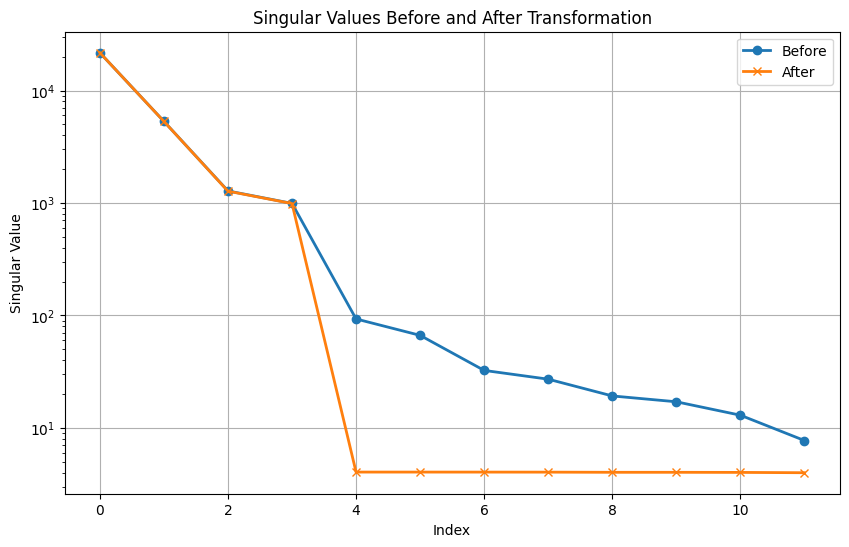

In [ ]:
# minimize_sigma_k_native.py
from __future__ import annotations
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Any, Type

import torch
torch.set_default_dtype(torch.float64)  # better SVD stability

@dataclass
class MinSigmaKConfig:
    k: int                                  # 1-indexed singular value to minimize
    lr: float = 1e-2
    max_iter: int = 2000
    squared: bool = False                   # minimize 0.5*sigma_k^2 if True
    data_target_weight: float = 0.0         # λ * ||A - A_data||_F^2
    reg_weight: float = 0.0                 # γ * ||A||_F^2
    box: Optional[Tuple[float, float]] = None
    fixed_mask: Optional[torch.Tensor] = None  # bool mask of SAME SHAPE as A0 (True=fixed)
    optimizer_cls: Type[torch.optim.Optimizer] = torch.optim.Adam
    optimizer_kwargs: Dict[str, Any] = None
    tol_rel: float = 1e-7
    verbose: int = 1
    device: Optional[torch.device] = None

@dataclass
class MinSigmaKResult:
    A: torch.Tensor
    history: Dict[str, list]
    cfg: MinSigmaKConfig

def _proj_inplace(A: torch.Tensor, A0: torch.Tensor,
                  box: Optional[Tuple[float, float]],
                  fixed_mask: Optional[torch.Tensor]) -> None:
    """Project A in-place to respect box and fixed entries."""
    with torch.no_grad():
        if box is not None:
            lo, hi = box
            A.clamp_(min=lo, max=hi)
        if fixed_mask is not None:
            A[fixed_mask] = A0[fixed_mask]

def _objective(A: torch.Tensor, k: int, squared: bool,
               data_target: Optional[torch.Tensor],
               data_w: float, reg_w: float):
    # Full SVD (robust & simple). Autograd handles backward for most nondegenerate cases.
    # If k-th value is tied, gradients are subgradients and can be noisy.
    U, S, Vh = torch.linalg.svd(A, full_matrices=False)
    s_k = S[k-1]
    loss = 0.5*s_k*s_k if squared else s_k
    if data_w > 0.0 and data_target is not None:
        loss = loss + data_w * torch.sum((A - data_target) ** 2)
    if reg_w > 0.0:
        loss = loss + reg_w * torch.sum(A ** 2)
    return loss, float(s_k.item())

def minimize_sigma_k_native(
    A0: torch.Tensor,
    cfg: MinSigmaKConfig,
    data_target: Optional[torch.Tensor] = None,
) -> MinSigmaKResult:
    
    assert A0.ndim == 2
    m, n = A0.shape
    r = min(m, n)
    assert 1 <= cfg.k <= r, f"k must be within [1, {r}]"

    device = cfg.device or A0.device
    A0 = A0.to(device)
    A_param = torch.nn.Parameter(A0.clone())
    fixed_mask = cfg.fixed_mask.to(device) if cfg.fixed_mask is not None else None
    if data_target is not None:
        data_target = data_target.to(device)

    # Initial projection (ensures feasibility before starting)
    _proj_inplace(A_param, A0, cfg.box, fixed_mask)

    # Optimizer
    optim_kwargs = dict(lr=cfg.lr)
    if cfg.optimizer_kwargs:
        optim_kwargs.update(cfg.optimizer_kwargs)
    optimizer = cfg.optimizer_cls([A_param], **optim_kwargs)

    history = {"objective": [], "sigma_k": []}
    
    last_obj = None
    pbar = tqdm(range(cfg.max_iter), desc="Optimizing σ_k", dynamic_ncols=True)
    for it in pbar:
        optimizer.zero_grad(set_to_none=True)

        loss, s_k_val = _objective(
            A_param, cfg.k, cfg.squared, data_target, cfg.data_target_weight, cfg.reg_weight
        )
        loss.backward()

        if fixed_mask is not None and A_param.grad is not None:
            A_param.grad[fixed_mask] = 0.0

        optimizer.step()
        #_proj_inplace(A_param, A0, cfg.box, fixed_mask)

        obj_val = float(loss.detach().item())
        history["objective"].append(obj_val)
        history["sigma_k"].append(s_k_val)

        # update tqdm bar
        pbar.set_postfix({
            "obj": f"{obj_val:.3e}",
            f"σ_{cfg.k}": f"{s_k_val:.3e}"
        })

        if last_obj is not None:
            rel = abs(last_obj - obj_val) / (abs(last_obj) + 1e-12)
            if rel < cfg.tol_rel:
                if cfg.verbose:
                    print(f"Converged at it={it}, rel_drop={rel:.2e}")
                break
        last_obj = obj_val

    pbar.close()

    return MinSigmaKResult(A=A_param.detach(), history=history, cfg=cfg)

# -------------------------- USAGE EXAMPLES --------------------------

k = 5
A0 = W_uni.clone()
M = W_uni.clone()

# Example 1: Adam (default)
cfg = MinSigmaKConfig(
    k=k,
    lr=1e-3,
    squared=True,                 # smoother
    data_target_weight=1e-5,      # stay close to M
    reg_weight=0.0,
    box=None,                     # e.g., (-5.0, 5.0)
    fixed_mask=None,              # e.g., known entries to keep fixed
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs={"betas": (0.9, 0.999)},
    tol_rel=1e-7,
    verbose=0,
    max_iter=int(10e3),
    device="cpu",
)
res = minimize_sigma_k_native(A0, cfg, data_target=M)
with torch.no_grad():
    s0 = torch.linalg.svdvals(A0)[k-1].item()
    s1 = torch.linalg.svdvals(res.A)[k-1].item()
print("\n[Adam]  sigma_{}: {: .6e} -> {: .6e}".format(k, s0, s1))

# Assuming `before_singular_values` and `after_singular_values` are the singular values
before_singular_values = torch.linalg.svd(A0)[1]
after_singular_values = torch.linalg.svd(res.A.cpu())[1]

plt.figure(figsize=(10, 6))
plt.plot(before_singular_values.cpu().numpy(), "-o", label="Before", linewidth=2)
plt.plot(after_singular_values.cpu().numpy(), "-x", label="After", linewidth=2)
plt.yscale("log")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.title("Singular Values Before and After Transformation")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
from auxiliar.depth_tensor_viz import k3d_3d_plot

k3d_3d_plot(costeira_marques(res.A)[1])
#k3d_3d_plot(costeira_marques(W_uni_nohomg)[1])

Outer Iterations:   0%|                                                         | 0/50 [00:00<?, ?it/s]

Outer Iterations: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 580.93it/s]


Output()

# Tests

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Z-values in the camera frame
im1 = axes[0].imshow(world_to_camera_rt(wrld_pts[0], extrinsics)[0, :, :, 2])
axes[0].set_title("Z-values in Camera Frame")
fig.colorbar(im1, ax=axes[0])

# Plot the depth tensor
im2 = axes[1].imshow(depth_tensor[0, 0, :, :, 0])
axes[1].set_title("Depth Tensor")
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

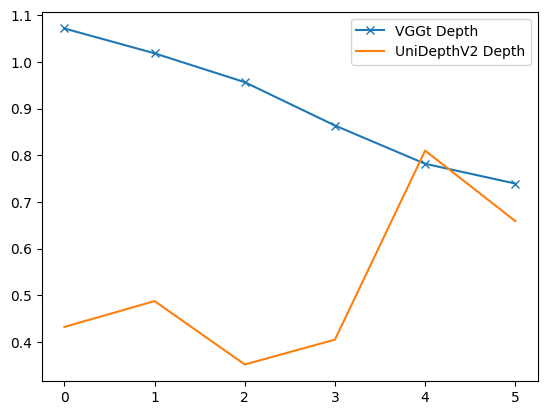

In [123]:
rand_feature =  torch.randint(0,tracks_lambda_vggt.shape[1], (1,))
plt.plot(tracks_lambda_vggt[:, rand_feature],"-x", label='VGGt Depth')
plt.plot(tracks_lambda_unidepth[:, rand_feature],"-", label='UniDepthV2 Depth')
plt.legend()

In [ ]:
#scales
offsets


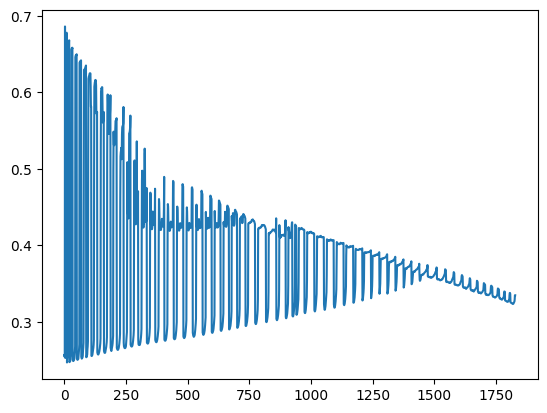

In [125]:
plt.plot(tracks_lambda_unidepth[0,:])

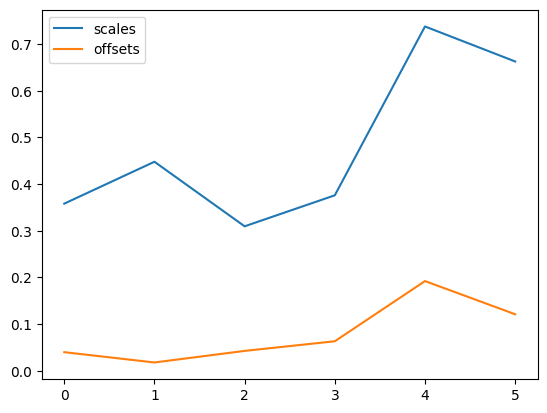

In [112]:
plt.plot(scales, label='scales')
plt.plot(offsets, label='offsets')
plt.legend()

In [124]:
scales = []
offsets = []


for frame in range(tracks_lambda_vggt.shape[0]):
    x = tracks_lambda_vggt[frame, :].flatten()
    y = tracks_lambda_unidepth[frame, :].flatten()
    A = torch.stack([x, torch.ones_like(x)], dim=1)  # [N,2]
    sol = torch.linalg.lstsq(A, y.unsqueeze(1)).solution
    s, o = sol.squeeze()

    scales.append(s.item())
    offsets.append(o.item())

    y_pred = s * x + o
    residuals = y - y_pred
    rmse = torch.sqrt(torch.mean(residuals**2))
    corr = torch.corrcoef(torch.stack([x, y]))[0, 1]
    print(f"RMSE: {rmse.item():.4f}, correlation: {corr.item():.4f}")


    # Left subplot: Video frame with residuals overlay
    axes[0].imshow((video[frame] + 1) / 2)
    xs = obs_mat[frame * 2 + 0, :]
    ys = obs_mat[frame * 2 + 1, :]
    scatter = axes[0].scatter(xs.flatten(), ys.flatten(), c=np.abs(residuals.flatten()), cmap='hot', s=10)
    fig.colorbar(scatter, ax=axes[0], label='Residuals')
    axes[0].set_title("Residuals Visualization")

    # Right subplot: Residuals plot
    axes[1].plot(residuals.numpy(), label="Residuals")
    axes[1].set_title("Residuals Plot")
    axes[1].set_xlabel("Feature Index")
    axes[1].set_ylabel("Residual Value")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

RMSE: 0.0132, correlation: 0.9867


/tmp/ipykernel_42473/3768254282.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scatter = axes[0].scatter(xs.flatten(), ys.flatten(), c=np.abs(residuals.flatten()), cmap='hot', s=10)


<Figure size 640x480 with 0 Axes>

RMSE: 0.0132, correlation: 0.9899


<Figure size 640x480 with 0 Axes>

RMSE: 0.0083, correlation: 0.9897


<Figure size 640x480 with 0 Axes>

RMSE: 0.0102, correlation: 0.9862


<Figure size 640x480 with 0 Axes>

RMSE: 0.0210, correlation: 0.9802


<Figure size 640x480 with 0 Axes>

RMSE: 0.0245, correlation: 0.9587


<Figure size 640x480 with 0 Axes>

In [ ]:
from src.projective_factorization import sample_depths

def backproject_points(tracks, depths, fx, fy, cx, cy):
    """
    tracks: [2F, P] pixel coords
    depths: [F, P] sampled depths for each feature
    Returns: [F, P, 3] 3D points in camera coords per frame
    """
    F, P = depths.shape
    u = tracks[0::2, :]  # [F,P]
    v = tracks[1::2, :]  # [F,P]

    X = (u - cx) / fx * depths
    Y = (v - cy) / fy * depths
    Z = depths

    return torch.stack([X, Y, Z], dim=-1)  # [F,P,3]

num_frames = obs_mat_depth_sized.shape[0] // 2

tracks_depth = sample_depths(depth_tensor[0:num_frames,...], obs_mat_depth_sized[0:num_frames*2,...])  # [F, P]

K = torch.mean(instrisics, dim=0)

pts = backproject_points(obs_mat_depth_sized[0:num_frames*2,...], tracks_depth,
                          fx=K[0,0], fy=K[1,1], cx=K[0,2], cy=K[1,2]) # all frames

X,Y,Z = pts[:,0].cpu(), pts[:,1].cpu(), pts[:,2].cpu()

#use rerrun to see the pts
rr.init("3d_backprojection")
rr.notebook_show(width=int(1920*0.75), height=int(1080*0.75))
rr.log("world/3d_completed", rr.Points3D(pts))

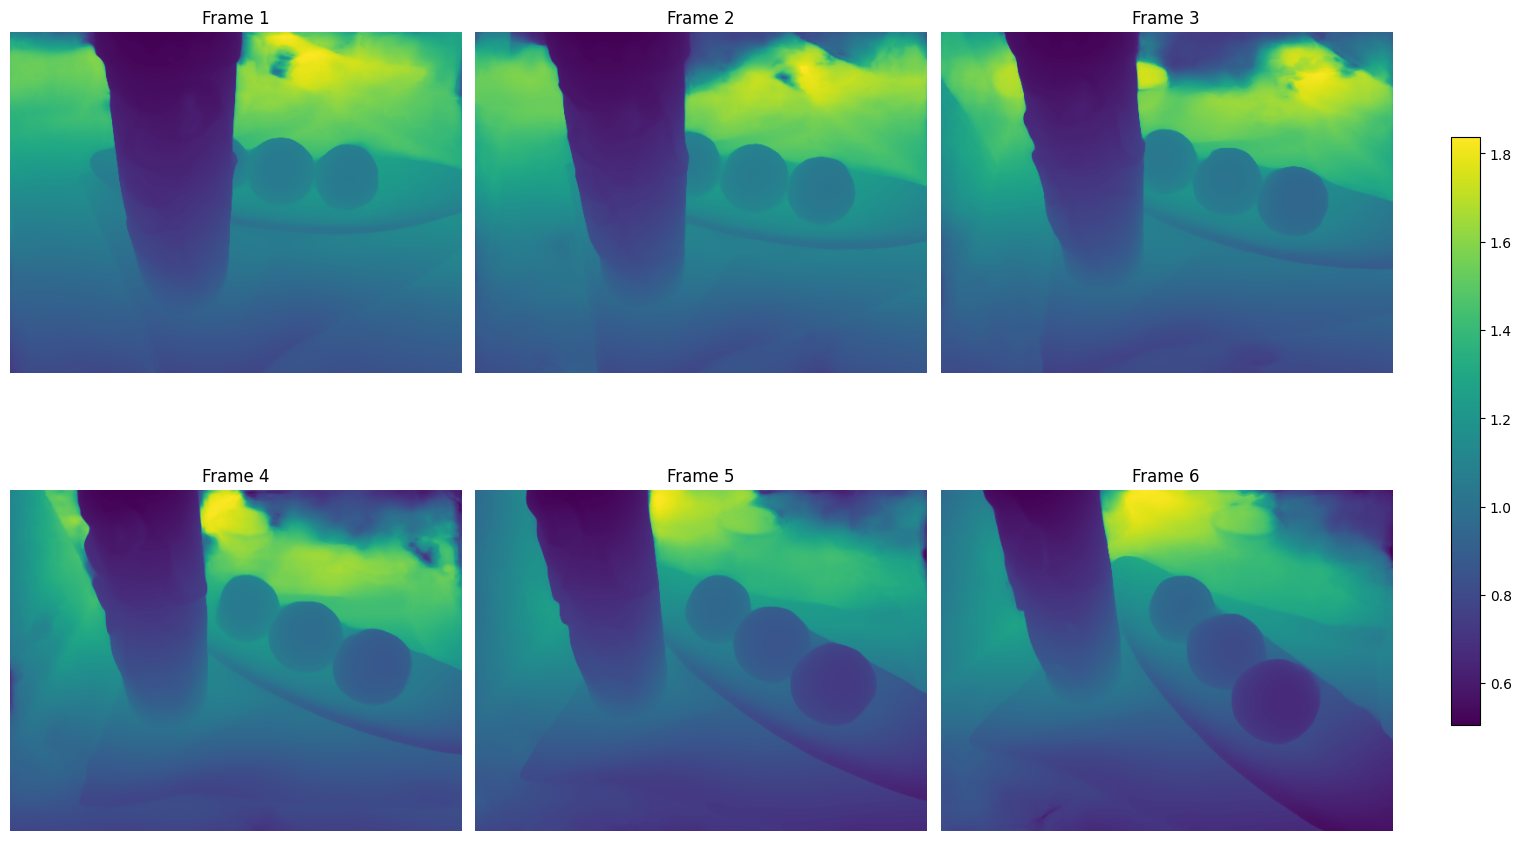

(<Figure size 1500x1000 with 7 Axes>,
 array([<Axes: title={'center': 'Frame 1'}>,
        <Axes: title={'center': 'Frame 2'}>,
        <Axes: title={'center': 'Frame 3'}>,
        <Axes: title={'center': 'Frame 4'}>,
        <Axes: title={'center': 'Frame 5'}>,
        <Axes: title={'center': 'Frame 6'}>], dtype=object))

In [72]:
from auxiliar.depth_tensor_viz import plot_depth_tensor_grid
plot_depth_tensor_grid(vggt_depth_tensor)

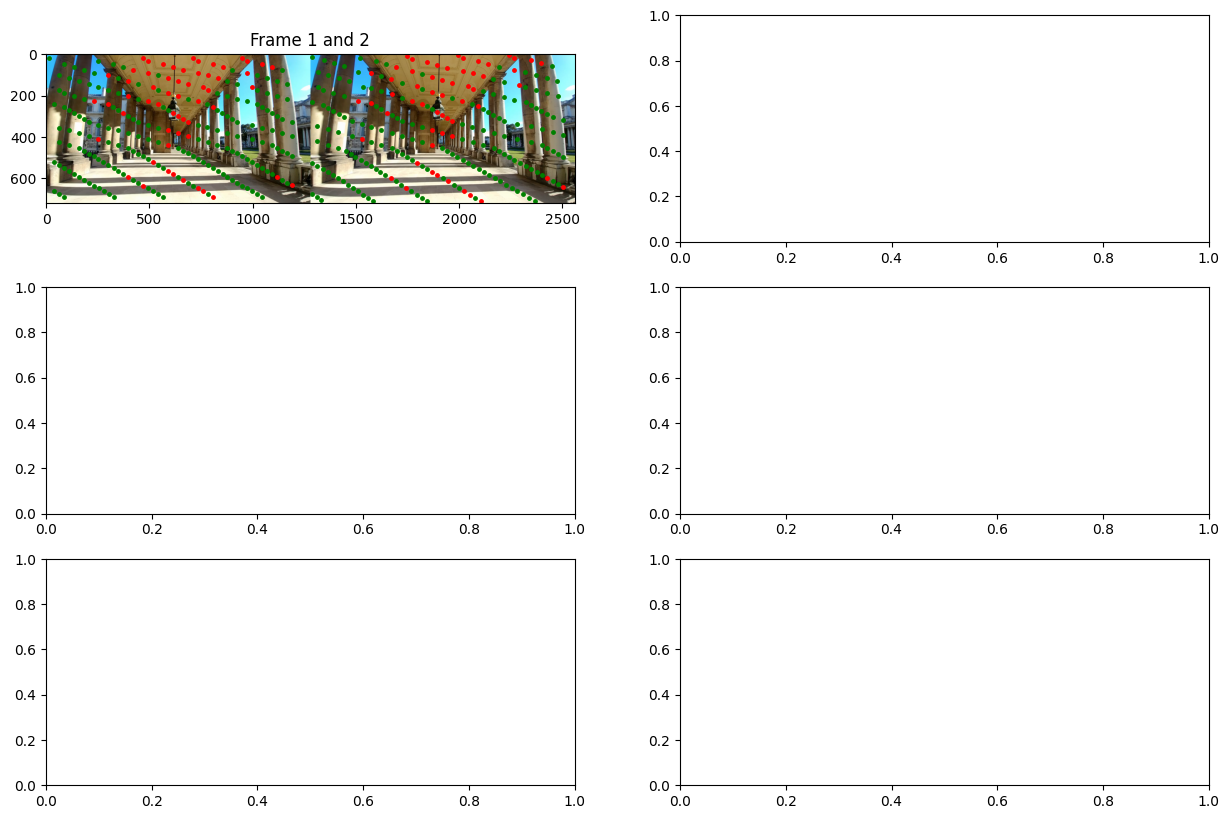

In [59]:
# Find fundamental matrices between frames
from tqdm import tqdm

fig, axes = plt.subplots(3,2, figsize=(15, 10))  # Create a 2x3 grid
axes = axes.flatten()

for frame in range(obs_mat.shape[0] // 2 - 1):

    pts1 = obs_mat[frame*2:frame*2+2, :].T
    pts2 = obs_mat[(frame+8)*2:(frame+8)*2+2, :].T

    F, mask = cv.findFundamentalMat(
        pts1.cpu().numpy(), 
        pts2.cpu().numpy(), 
        cv.FM_RANSAC,
        ransacReprojThreshold=1.0)
    
    # show both imaegs side by side and represent the outliers
    img1 = ((video[frame] + 1) / 2.0)
    img2 = ((video[frame+8] + 1) / 2.0)
    combined_img = np.hstack((img1, img2))
    axes[frame].imshow(combined_img)

    for i in range(0, pts1.shape[0], 10):
        if mask[i]:
            color = 'g'  # Inlier
        else:
            color = 'r'  # Outlier
        axes[frame].scatter(pts1[i, 0], pts1[i, 1], s=6, c=color)
        axes[frame].scatter(pts2[i, 0] + img1.shape[1], pts2[i, 1], s=6, c=color)  # Offset x for second image
        axes[frame].set_title(f"Frame {frame+1} and {frame+2}")

    break  # only first pair for demo
